# Direct mixture separation

## Load packages and functions

In [1]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using LAR
using LAR.Node
using FFTW

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
include("../functions/auxiliary/warpedfilter.jl")
;

## Adjustable parameters

In [2]:
# signal preprocessing
sound_file_1 = "../data/drilling.wav"   # specify sound location of first mixture component
sound_file_2 = "../data/obama.wav"      # specify sound location of second mixture component
fs_desired = 8000                   # specify desired sampling frequency

# parameter loading
param_file_1 = "inferred_values/drilling_AR20.h5"
param_file_2 = "inferred_values/speech_AR20.h5"

# inference and modelling
AR_order = 20                         # order of auto-regressive model
iterations = 3                       # number of iterations for variational message passing
Λ_meas = 1e10                        # assumed precision of measurement noise
;

## Load and preprocess data

In [3]:
# load and process first mixture component
x_1, fs_1 = wavread(sound_file_1, format="native")
fs_1 = Int(fs_1)
x_1 = x_1[20*fs_1+1:23*fs_1]
x_1 = resample(x_1, fs_desired/fs_1)
x_1 = 100*x_1/var(x_1)

# load and process second mixture component
x_2, fs_2 = wavread(sound_file_2, format="native")
fs_2 = Int(fs_2)
x_2 = x_2[20*fs_2+1:23*fs_2]
x_2 = resample(x_2, fs_desired/fs_2)
x_2 = 100*x_2/var(x_2)

# Combine signals through simple addition
x_tot = x_1 + x_2

# create time axis
t = collect((1:length(x_tot))/fs_desired)

# create audio players for demonstration
audioplayers(x_1, x_2, x_tot, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQCVfEg869jxuyXjqLxEVnC8iNN6O1ZezLxFIUg7U6YdPUslG72mF6C9M7k+PGE7Xz3cuSA9gqi0vHSN/jxRw4+8uuaIu8QE7Tsuyds88qELPTmM47x10jC8VkULvGxvJTw2bS67XT35PJgVAbzFHLy8TscdvfVuhTv0zhY8hkZnO6VsiLyDJ9I7MqG3PHmMarzDCl27GITVO3XtZLy+2BC9bBezvKBYIDupdx89yEZourVOljzAXMI8lJoAvWwHvbrSl6M8XM1HukQu07s46tE8oHy+PK/3rbvB8ua8MnuYPHcJqryi0tU8O17vOwKXRDz52xm8nUoXPC7Al7x8Io+8H0e3POYZlzzfZva7kqdFO0KRCz0V+DG9p23ZPLi0lr22hqA8x+eoPFhd9LpSDgW9d997PJgSgLwpphu9zeYxPI9WU7xuiuY8gCwOvYYqHj1i5v68/QCivKuMEzuc6KW7Hll3vM2KODqC7zU9kgEXvVGheDw9Vq48jWLbPFL8eryHcOU7i0lTPYWhKr049Ds957uOO3oomrzTIMq8h63NPDRmkbygpD28PmFpPPtW6zyo7Xm89fgvvdq1Yj0drAM9gmuzvDDfMr2zDK+7MgyhvJH/k7wFqPw8vCDcPPfJKjyiUhW9giA+PMDu2TlATAG85i6VumxOkTzIv+86xyjMPJ/SZDzEDH281wY+uh+ftLzWjm08gW9CPFW3CD0G/nK8YBa2vG64mLz/M+I7pKkauxyb7zw0Sr+8tBdDvc0uC7s7Gxe99oXXujQyVzzoCjA8MjOpPB+s57u9Yoo6obbgOdr2+LxWjAo8bO+8PFDFD7wd6vc8BPQVPKMpLzx+4w+9Q8nbOjyxTDzvNB+8mK08vPZBzTy5Uog7CLkIve6KLD2B3uQ8YXaivIKpGLw86xE8zcfJu8ZnDr2Jzsm8CfPRPMYthD0lZQg9uPLkvMp8pLzWaMS8R+FivPfsIz0rfig957nvPOpBwrszBce88skMvZRvOb2bta068n8DPRTQubyCC108Dt4xuk16Tb2H+2e8HH/MOyd+n7zxUSq9+vybOxor3zx/4No8XL8hPFGvpry0Jia862ghvMu08bvcCMU7+KEjPUQZKTwVUFU9KhMTvVBvv7x6mGu7I5L5PDSBC71PMT49BXBZPJhsJTxjNw290xwhPNNyDz2Wa9c8ycm4vH5sHr3ZxqU8JC4dvSSiQjxIGNE8so2jPb3TFb0O55Y84yMTvWiZFb3zZ0a8vK39PBxJfDwR+m68xjERPX53pLzYRRG9gh32vCSiALzf2M08EqB/vRd93LqXKkM8pSBjO3+m/LuIy+g8MNSCPAj4TL3TNhC9Ecz2O5BnlTznE1W7lFdyPXb/ozx4lca7r5ATvIbKPjwHfow78TYdPSYKfrxfNg28E+qUvSaQATxFf0I8djdfPNNUx7x/iEw96amLu8/TMjzLwle9jQ2jvEABFT1NQ589Hr/ku/hWRb1Er5G70TMHvYPO7zzQZnY8vSNPPYIed7z2jyE80impvD/Wjjv/93m8S3KmOgbpTzy9KuA8Q6B3vSQWr7ytPha7d97TPK2Z+TyCrnK9QbSOvM9rNb3XYYC82Y7NPDz/YD21fsg8qtyrvOLpGbynfSK9Oy3kPEFnkLvOhRQ9hgUKPfuK8LyQFky9hAiEvPL6zLw2OBk92Gq+Pd2hnrwYa2a9SvUTvVhB9jzg/xI8mWCJu467HD0dhG48aK6HPILdab3Rkxo9LeQhO3dELToUPB09a1m/PJ6x97x7jUa9XNRWPBFLejzDTfg8Nf+lu03B5jwJxSy8rwM5vdGszrzRUTY9+UutO6MPeb1vaIA8vL6mOvCUIzvQcQi90uJ6PJ1xs7z5rx2936lkuxuEMrzYxck8t4AZvOnLrzy3QfA7cTKoPJtln7zkEi09v0w6O154fLzKxgM92aEgvBaNTDxoSa+8wKMqu7qDhbyM+Bu8KZcaPTSr0Dwqsj+9Fmn1u6r5L71FVOU8tUR3u0cJojyxvDo9dqIaPYA6+byzxV69sSwAPC9jizsUNqM8o1/wPBOj0DkHhYI8LL3ovFc1nbzBLP288SvePAgN4TxCwI288IMVuYIDBzwNHLQ7z1WtvJMLxrx1PRS9J1RuvKMyg7vPv9Q8luGJu46TIT0ZPPm8O1THvJM4pTv8mqy8WpFkPXcZMTwUSTI78JQMPBwj8bz/kQ26nQ+luwxVRz3z4J48YWg9vYi6pbyLpiA8zej2uw4GhDtF6Wc9ovJtu8om2ztvR669gE2Xuw1HlTze3RQ9qdWkPLyqDj1Vw488nNj8uyDZ7DsAWWa9iPFfvIpu6Dsw18c83niePCpCLT2W2GS8UXPwvMT7X739eMi8620GPAw9b7tV+Z28cG32PF1D3LwG1ee8zJoDO2EM4ruOSDo88pwhuwwLBTxhkcy72/O2u1bq1DzyZHU8TpBOvdxqxjwARwo97/rxPEqYFLzwtiU9/1FbO2RRO70J4RO94EkrPeNpCj1rgha8X2P9vAh4r7sb6Ue8EVUGvfDutzv4uS09zEFpPYULxLuY/oK83pzevH6XM7x94qY7rzpwPdFydLqa1C08uqKOvAdos7xN0se8l+QbPOf5T7xcH/C8aQGAPLnMHj3+Hcy8aZVPvG8MaLygv2e7m8acvIuS0btnqXE8zp+tvMfOxjxEKNQ7ywwJO/5BMb2swoY8gp3lu2TfxTykdVU8CRugPLzokry9LR66NE2DPP2tE7yfC3e84tlPPKeYpDzO2Ak9IJmQvM7a5LxB0ie7HDBCPXkJwbxxq9s8omWeuyZjJb1Ofiy7emuGOxA5ijuS/4s6zPkEPT1zhjxaiRA8jNPivBesWzyoTGS8eWlVvBAXxTzudUA7mdORu/uPFDzy9We87CQ6vCYWSb0JNcU7xrcHvJpZ4jsxGba8zmcEPCAaQjyKhYk7gB6mvEI5nrzeZWE7ZLxevLndSbum1rc8AUkWu7KEiDs35A48ani7uzgjXz2NDU+6Tl2jvD8iCD0YRm28d0b+vNxhQby68zU9G8MuPcJUBrwdsRG8raGOu9USEjzL5xm9oxaYuyL6mTtdzJ+8uF77PDZEyjzaaxq89RPkvKDP/zssKIE8IWu8O3qk0zuQkeo8rGSuO4Z6GL073x69XYYTPGdRsrxCMoe79dotuwLxRTyPmTg8U27Zunm/ML2mTWI9/MkavNZQ+7zEdES7cKc5u6e23DxSIc+8HPjXvFimjLy/pcM8AoMePHuuC73EvBc9Z07KPHPQuLwaqK25Z+ksPV8HozkMYxe8uqa9PDTJELpyABu9WfOTO+z/MT15xpQ87jisPAG25jwsW/S6q/GcvapzwLr/KBg8hk8KPLktM7xUcSk9tnaFPJsMm7zI2Um9yHVJPMA3nbveZBG8IciOuuUXaTw2CfQ8KDtBPGKiIL0lsk29jtHnvD0kmzyxKgM8JzPqOyhdmTyWkCG62BxAvV8wvLoodIs7ItFwvKuy9byWFVs8HC7iPHfmxjt9EgC83CHqvJm63jzOugI9YnHWO7SkNTyBc3k9i/SFOgcK6LxNnTi7+KTGPA4vITxsNEg8XKOzvIoAQDwwX3s74iDjvMTfpbxU11m8kt31O33PxDyOoZe7uYBzPALx6byoZn68Md+VvNxY2Tw7oXY8ljBgOXWRJbyV1xW8gC+sO4sqLL0dEc27Dqv1vDiAtjxBkXQ8YySuPACYArxRO0O86zQlvMKemLzze9K7o9NHPMZUHD0Ytac8mB24vOFHJrxWPZy7B72dvCXz6rxS0Y08y6YXPev4CD0NIii9CYHSuhpOeTwIttQ89A17Oz3GcLxHBSI9Z2k/PEO+Mr2aq0U8ormtPBXqJTxPZ

## Visualize data

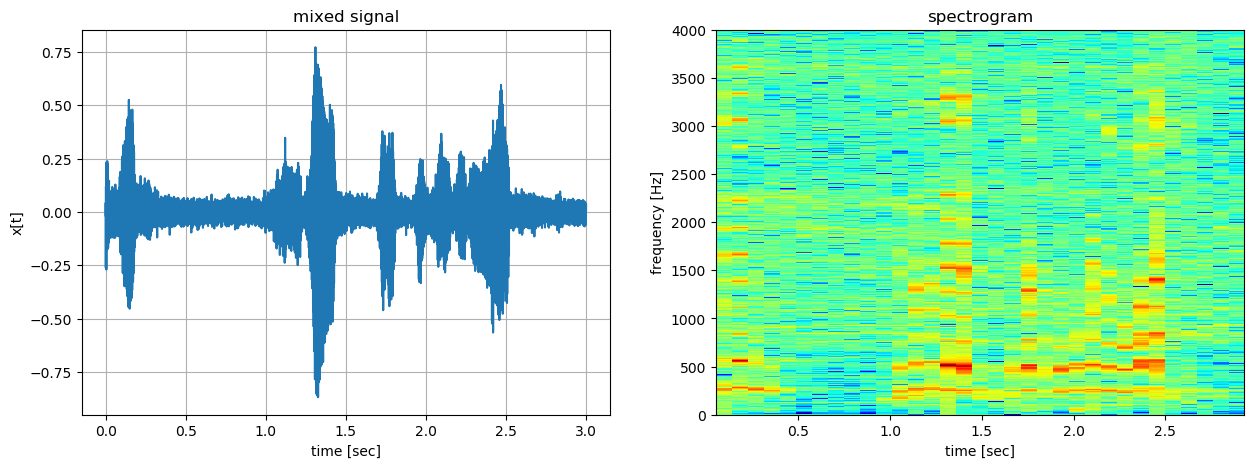

In [4]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_tot)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_tot, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("mixed signal"), ax[2].set_title("spectrogram")
;

## Load parameters

In [5]:
params_1 = h5read(param_file_1, "parameters")
params_2 = h5read(param_file_2, "parameters")
;

## Create generative model and algorithm

In [6]:
# create factor graphs
fg = FactorGraph()

# AR node (source 1)
@RV γ1 ~ ForneyLab.Gamma(params_1["a_gamma"], params_1["b_gamma"])
@RV θ1 ~ GaussianMeanPrecision(params_1["mean_theta"], params_1["precision_theta"])
@RV Sprev1 ~ GaussianMeanPrecision(placeholder(:μ_Sprev1, dims=(AR_order,)), placeholder(:Λ_Sprev1, dims=(AR_order, AR_order)))
@RV S1 ~ LAR.Autoregressive(θ1, Sprev1, γ1)

# AR node (source 1)
@RV γ2 ~ ForneyLab.Gamma(params_2["a_gamma"], params_2["b_gamma"])
@RV θ2 ~ GaussianMeanPrecision(params_2["mean_theta"], params_2["precision_theta"])
@RV Sprev2 ~ GaussianMeanPrecision(placeholder(:μ_Sprev2, dims=(AR_order,)), placeholder(:Λ_Sprev2, dims=(AR_order, AR_order)))
@RV S2 ~ LAR.Autoregressive(θ2, Sprev2, γ2)

# selection and input
d = zeros(AR_order)
d[1] = 1
@RV x1 ~ DotProduct(d, S1)
@RV x2 ~ DotProduct(d, S2)

@RV v ~ GaussianMeanPrecision(0, Λ_meas)
@RV y = x1 + x2 + v
placeholder(y, :y)


ForneyLab.draw(fg)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 4386537077281533718 -->
 4386537077281533718 
 
 clamp_12 
 
<!-- 16906866586367557680 -->
 16906866586367557680 
 
 𝒩 
 gaussianmeanprecision_4 
 
<!-- 1491239382689793323 -->
 1491239382689793323 
 
 placeholder_Λ_Sprev2 
 
<!-- 16906866586367557680--1491239382689793323 -->
 16906866586367557680--1491239382689793323 
 
 Λ_Sprev2 
 1 out 
 3 w 
 
<!-- 6173600662111291987 -->
 6173600662111291987 
 
 placeholder_μ_Sprev2 
 
<!-- 16906866586367557680--6173600662111291987 -->
 16906866586367557680--6173600662111291987 
 
 μ_Sprev2 
 1 out 
 2 m 
 
<!-- 9141410792015581408 -->
 9141410792015581408 
 
 + 
 addition_2 
 
<!-- 816311438779227240 -->
 816311438779227240 
 
 𝒩 
 gaussianmeanprecision_5 
 
<!-- 9141410792015581408--816311438779227240 -->
 9141410792015581408--816311438779227240 
 
 v 
 1 out 
 3 in2 
 
<!-- 15740938056133009868 -->
 15740938056133009868 
 
 + 
 addition_1 
 
<!-- 9141410792015581408--15740938056133009868 -->
 9141410792015581408--15740938056133009868 
 
 variable_1 
 1 out 
 2 in1 
 
<!-- 2745563991950595183 -->
 2745563991950595183 
 
 Gam 
 gamma_2 
 
<!-- 16047353822319120552 -->
 16047353822319120552 
 
 clamp_5 
 
<!-- 2745563991950595183--16047353822319120552 -->
 2745563991950595183--16047353822319120552 
 
 clamp_5 
 1 out 
 2 a 
 
<!-- 17460382906421526846 -->
 17460382906421526846 
 
 clamp_6 
 
<!-- 2745563991950595183--17460382906421526846 -->
 2745563991950595183--17460382906421526846 
 
 clamp_6 
 1 out 
 3 b 
 
<!-- 14263737131233827876 -->
 14263737131233827876 
 
 dot 
 dotproduct_2 
 
<!-- 1224610913749010727 -->
 1224610913749010727 
 
 AR 
 autoregressive_2 
 
<!-- 14263737131233827876--1224610913749010727 -->
 14263737131233827876--1224610913749010727 
 
 S2 
 1 y 
 3 in2 
 
<!-- 3182322708314437409 -->
 3182322708314437409 
 
 clamp_10 
 
<!-- 14263737131233827876--3182322708314437409 -->
 14263737131233827876--3182322708314437409 
 
 clamp_10 
 1 out 
 2 in1 
 
<!-- 15400738650846998983 -->
 15400738650846998983 
 
 clamp_1 
 
<!-- 6650687592250412429 -->
 6650687592250412429 
 
 clamp_4 
 
<!-- 18326548714386643847 -->
 18326548714386643847 
 
 Gam 
 gamma_1 
 
<!-- 18326548714386643847--15400738650846998983 -->
 18326548714386643847--15400738650846998983 
 
 clamp_1 
 1 out 
 2 a 
 
<!-- 7274130242745154404 -->
 7274130242745154404 
 
 clamp_2 
 
<!-- 18326548714386643847--7274130242745154404 -->
 18326548714386643847--7274130242745154404 
 
 clamp_2 
 1 out 
 3 b 
 
<!-- 1224610913749010727--16906866586367557680 -->
 1224610913749010727--16906866586367557680 
 
 Sprev2 
 1 out 
 2 x 
 
<!-- 1224610913749010727--2745563991950595183 -->
 1224610913749010727--2745563991950595183 
 
 γ2 
 1 out 
 4 γ 
 
<!-- 2800714442958279493 -->
 2800714442958279493 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 1224610913749010727--2800714442958279493 -->
 1224610913749010727--2800714442958279493 
 
 θ2 
 1 out 
 3 θ 
 
<!-- 10061566361899095207 -->
 10061566361899095207 
 
 placeholder_μ_Sprev1 
 
<!-- 3763468823434660021 -->
 3763468823434660021 
 
 clamp_3 
 
<!-- 13008492617297131324 -->
 13008492617297131324 
 
 AR 
 autoregressive_1 
 
<!-- 13008492617297131324--18326548714386643847 -->
 13008492617297131324--18326548714386643847 
 
 γ1 
 1 out 
 4 γ 
 
<!-- 15368814955618233974 -->
 15368814955618233974 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 13008492617297131324--15368814955618233974 -->
 13008492617297131324--15368814955618233974 
 
 Sprev1 
 1 out 
 2 x 
 
<!-- 2807290982647410333 -->
 28072909826474103

In [7]:
# specify recognition factorization and create algorithm
q = RecognitionFactorization(S1, Sprev1, x1, S2, Sprev2, x2, ids=[:S1 :Sprev1 :x1 :S2 :Sprev2 :x2])
algo = compatibility_fix(variationalAlgorithm(q))

# evaluate algorithm
eval(Meta.parse(algo))
;

## Perform inference

In [8]:
# priors
current1_μ_Sprev = randn(AR_order)
current1_Λ_Sprev = tiny*diagm(randn(AR_order))
current2_μ_Sprev = randn(AR_order)
current2_Λ_Sprev = tiny*diagm(randn(AR_order))
current1_μ_x = randn(1)
current1_Λ_x = tiny
current2_μ_x = randn(1)
current2_Λ_x = tiny

# placeholders for predictions
x1_μ_pred = Float64[]
x1_Λ_pred = Float64[]
x2_μ_pred = Float64[]
x2_Λ_pred = Float64[]

# progress bar
p = Progress(length(x_tot), 1, "Observed ")

# initialize marginals and data dictionary
marginals = Dict()
data = Dict()

# loop through signal samples
for sp in 1:length(x_tot)
    
    # update progress bar
    update!(p, sp)
    
    # update marginals
    marginals[:θ1] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_1["mean_theta"], w=params_1["precision_theta"])
    marginals[:γ1] = ProbabilityDistribution(Univariate, Gamma, a=params_1["a_gamma"], b=params_1["b_gamma"])
    marginals[:Sprev1] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=current1_μ_Sprev, w=current1_Λ_Sprev)
    marginals[:x1] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=current1_μ_x, w=current1_Λ_x)
    marginals[:θ2] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_2["mean_theta"], w=params_2["precision_theta"])
    marginals[:γ2] = ProbabilityDistribution(Univariate, Gamma, a=params_2["a_gamma"], b=params_2["b_gamma"])
    marginals[:Sprev2] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=current2_μ_Sprev, w=current2_Λ_Sprev)    
    marginals[:x2] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=current2_μ_x, w=current2_Λ_x)
    
    # perform VMP iterations
    for it = 1:iterations
        
        # update data dictionary
        data = Dict(:y => x_tot[sp],
                    :μ_Sprev1 => current1_μ_Sprev,
                    :Λ_Sprev1 => current1_Λ_Sprev,
                    :μ_Sprev2 => current2_μ_Sprev,
                    :Λ_Sprev2 => current2_Λ_Sprev)      
        
        # perform inference
        data, marginals = step_all!(data, marginals)
        
        # update current parameters
        current1_μ_Sprev = ForneyLab.unsafeMean(marginals[:Sprev1])
        current1_Λ_Sprev = ForneyLab.unsafePrecision(marginals[:Sprev1])
        current2_μ_Sprev = ForneyLab.unsafeMean(marginals[:Sprev2])
        current2_Λ_Sprev = ForneyLab.unsafePrecision(marginals[:Sprev2])
        current1_μ_x = ForneyLab.unsafeMean(marginals[:x1])
        current1_Λ_x = ForneyLab.unsafePrecision(marginals[:x1])
        current2_μ_x = ForneyLab.unsafeMean(marginals[:x2])
        current2_Λ_x = ForneyLab.unsafePrecision(marginals[:x2])
        

    end
    
    # update current parameters
    current1_μ_Sprev = ForneyLab.unsafeMean(marginals[:S1])
    current1_Λ_Sprev = ForneyLab.unsafePrecision(marginals[:S1])
    current2_μ_Sprev = ForneyLab.unsafeMean(marginals[:S2])
    current2_Λ_Sprev = ForneyLab.unsafePrecision(marginals[:S2])
    
    # save predictions of separation
    push!(x1_μ_pred, current1_μ_x)
    push!(x1_Λ_pred, current1_Λ_x)
    push!(x2_μ_pred, current2_μ_x)
    push!(x2_Λ_pred, current2_Λ_x)    
end
;

Observed 100%|██████████████████████████████████████████| Time: 0:02:58m


## Drilling sound

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQBdyoC8JHWEvlIoWb1A0DI9/BnOvZzX1L2br4W+132nvUuewbzXmeW90fkiPXsSfb2hVcK76mX1PRb3rz2pOME89QZsvXzjVryDZu496s8VPW+irr3tSPG8r63SPFIlbT6EyOc9TRzTvZptKz0D9Pk9JfsePpl2Kz1aZ0K+Z/BdO/g1Pb3ubv29naqsvXAUir7vfeW9T4yHu0p4hrmlol09mej8vZFpjL1FrAI+wL2QPdPLwT2ha8C7MoiqvcqUNz3pspE8WZK8vM3lVDunn5I9aIlbPnEI2j2Ofsq9txf3PbhzyT3c4zI+51yaPIiCJb6BaTg8it9QvWJIGb4Lj569r0YmviKcRr2WGdW8WnzRvGWJyz1OUDa+B4IuvSEI3ztrtuI98I0iPt9YQrrRUJq9hEzYPJevgL0juJS9vHkxPf7OqT3LN3Q+WkgyPR/sDr0DooM9G52YPVM/BD7Mywa9megxvqiC0zzCFxe9Gokkvssxk71lcxC+rSh6vOmrk717zfW88dF4PUqgIL5RrgQ9V0/cPSMKtz0b6609z8yjvBUNl72eEMe8zHi0u73Y9TyFzpA9F0eyPY6VZT6HGLA9OsfevSquaj2Nx+Y96DLPPWBwPb11QAS+hnNpPbuNpr1fWAS+kPCBvS6CK75ZEnC9OIy1vXaS9LzGkRY8TuGlvTN8azwXo6M9kvGJPZl6sTyjSoa9wirqvClmTD2AXbQ7YNwDPW00DT1Bdwo+cuENPotp0D033Te9BURGPeIJCj7+0RI9lukivZTME74AKtK7aKoivUARm71oxgy97XEIvg3R4b2tm669umyHvOunMLwQDaS9KAWGvENZcz0bbts8Q7ThPCiqVL0JG8u8Xl/hO6Ldbj1poqE9YP0xu2Z6Dz5k4xU+dpZXPQW9zjx3m4Q9BHqVPTbyLrtVqHu9zv/7vHu1fT0oOT89pGQ5vV6zfL28i6u9Ez3QvReAZb0xdyM9StNQPeWXkL17q5y9YqSZvWvMQr0TtBC8aq2NvIfx2LxkhA4802qoPJwPPbxNnLe8DW+jPHO0MDzrlA68MZzIPIYScDxpWHo9Di6FPTcRhDyV4SU9UqwOPcCVoDwxvc482kPqPCl0QzzXm089o00UvUr3KjvEC7a7czPvvEnv2b3PSii9e64wvT6cHrwu65m9ByCgvJ/tMDwDntq5anhSvdV+ib1Felk4f5WFvduIErwNEuo8cBjIPSMNL7wb53A9tRkAPQjuR7qYOww9U16qPapMgT0NLyU9DJexPbQcyDzeOC08FE/HvAC2Bb0v6EK82974vZmgML1aLcm7cqsAvIPr1rx+uFK8F8MTvWegk73GKk+9BB8ZO5dEHTx5rMi8KPEEPW181LyHwUa9yoM7vJOfYTyTJJA72exzPSN5nzts9jU9oJVMvGe7qj3r7LA9VjeNPZJraDuR6Zw9hDxQO9Y+6TvBsUa9OfUgvJCdDD2V6m09PqsQvf6ap71viCa9kgSEvYHMNDzjxR67IqNNPGTLfb2hjHW82Yn8vMiDPbqgpC29hMH1vOudJ716sJS8oraPvXwUy7oi9hQ9P7+kPRJWqj1ypEa8VIijPOBIw7zUOVA8xDJ/PcOknD35s3o9KCfeO0SW8TulqUa8SqlOPPBUErwR0nE8ObzxvHupkr3058G9bMFXvSIie7zXdjE9JCeQPcUseL1y/s+94c2Lvb5f3Llt0Yy7BQTiu7qCozx6yIE8diGPPDREb71m2Gw9brt6PLmVcD3c+fA9YlSqPeDYbDxWcQy9QS1iO950xjw7WE091EMGPPgsDD3CV7i85yGCvb0Z0ryzk/s80wacu9m6tL3KBui8wjtHvLk2jTm56ZC8YZTaPLrlV73XKrq90CFmvUfGk70O+TG8cWNGvEarID3fynw9shaHPe3M2jwXGaQ9g7X+PDxh9zzpb4c9q2XVPLxONT2z1ZW84W/kO4u0vLx0st28FDH3PKkiaDxyl2y9OLNhup5YRb1oHR48UuP3vLc1o7wGLIS7Y5hMvElEjr1MsPW9+IFyvU+pKb356rG7zvnsPJ7ZGbpM4JM8e4cHvAY2Cbw51u06rgy4PcfpoT2tGCc9VbNRPZCNPj1GEC49jtM3u8Q1hbwc9/K8yijSvFQY3zlBKqU8SR+6O5hZjD3sC+K86e0fvd4BEr02zaS9S1uBPECkCL3O2VO9+wubvEzAiL2dheG8i6JuvEN9HT2xNYg7IN5gvfHDCL1apdU8tfIXPK67HT2Zctw9QaJePW1ktT1aYvq8ERLgPP6+fD2FHaA9JLiLPRCShD2tzD08gqrxvI892bwfxKW9SvSWvMQAHjtXw+i4RkIjPDS+cDwKgdm8A3t4vczD9r1citK9fteNvZ8tk73SoYq9QsCzu6YJKr2h8AW9JvQQPLDEbDyzNMY87wi5PE8leD0nAns91j2TPWRwyD2r/Yw9JQCovHtFpzzi8tE8Nf3JO/buLr2jJiQ8OmIou9jtEr3VLHK8GMQgPdeN3DxTlxi9Wo6WvXxQjr3nF8y9zoL0vbTrnL2Z2uq8mik/PIrfFb1ZkvS8BxXsvAe+a7rNbkI9qtYDPjPjvz0W2to9J61kPVAq/zzXgNY8PhPpPAX6vTyk1rC7w3H5PPPJez2FSFi8cTwHu9HUOrsACn+83Q6SvInn07xQehO9tjOJvYGvVb1xFlS9vU0dvf9For19tB+8U9ZWvWxCV7wusry6UHIBPbKUCD0O3xs9OjuBPRNUSj3Urig98biNPQ8utT1e+cs9DV83PUIk2jxQyQI9i2aoPTSXWLt9rh49tttWPKpN3rzuJXK78pWovNcONr07ZBS9E/6fvBICGL1HXS698OfKvYXCJL0hHzW9QhgDvRccHj134l48Y8rdO3WoPLxhela9rS7CvOP0R70M0Hg91rRzPXFhoj0XAlo9aB2pPbzAvj08vqo96cQAPaaDBT1NxqI8XlyHvHU3ALwiT6g8YgU5u2IRsLziRGW9GhGgvVu3Dr1/e469OkCHvRkdabxLewy9tjeDvbLITL3u6Qg8wqS1u+majb06cz69RVs5vctFTbzPOWq9QNgSvNyzMD1BKRE9QfayPcDBtj3tOTI9q5UXPLhcFD22QYS62ZIzPMTiZDpUDge8s0oAva5F5r1BO6O9oWa9vA8lUr2ZWnK8EvwRvT6QfrlWjn+8039IvYfUuL2TBRk86zVMvUXSLr0ef5y8pN6xvB5VTTyXKii9AR59PLRx87lBwpA9brTPPHq8SzwYr849fdWOPRDSgDyYVVm5FojAPKrvPjp9OxK9nGv7O2IpoLyqLoa9SQmhOpVIMT3Y5Qy82t4Uva4yEb1RuoC9sj2+vdB8KL1ojxK9JHLQvF5ipL2mxAc9tnx/vJ+ME7xWnAe97qJVPaqukz2t3xI91WumPUCKhz0cmZQ9s9WEPVwgFb3KSrG8NJ8mvSxqVj1v8qw9AHkmPdUchT0F4jy91418vUl3QL0g/V68GpK4vPNEfr10/S08uMwuvNlJArwEhVi983CVvSu2ZDyCp9Y6jM/tuooK3ryWfek947gzPYmRuj2SFac9i6zkPU3TzTtfcpW7o6WkPTVqhT3qFuc9LjjovKmWILy6WX099JdMvPO7hT0CLo+8L5vmvOs5Bb38L3+9C7CmvDNc97xx7le9dxHfvMyYB72/rHK9nplWvOTQtr2xKD29tKLgvLBBVz2c6qM92WC+PXlYjj348q49XltEPS0oE73swws+NATqPeK3KD4O/RY9Uijsvd8Zbz2w/pS9IYlUvQoVn73QIfy9p2QzvFuE87xDF5W98YcIvVwN7b3yHq28GNWsO+M5P71c+0M9HUcsvHXgJb371GU9mH42PVojhD1jh

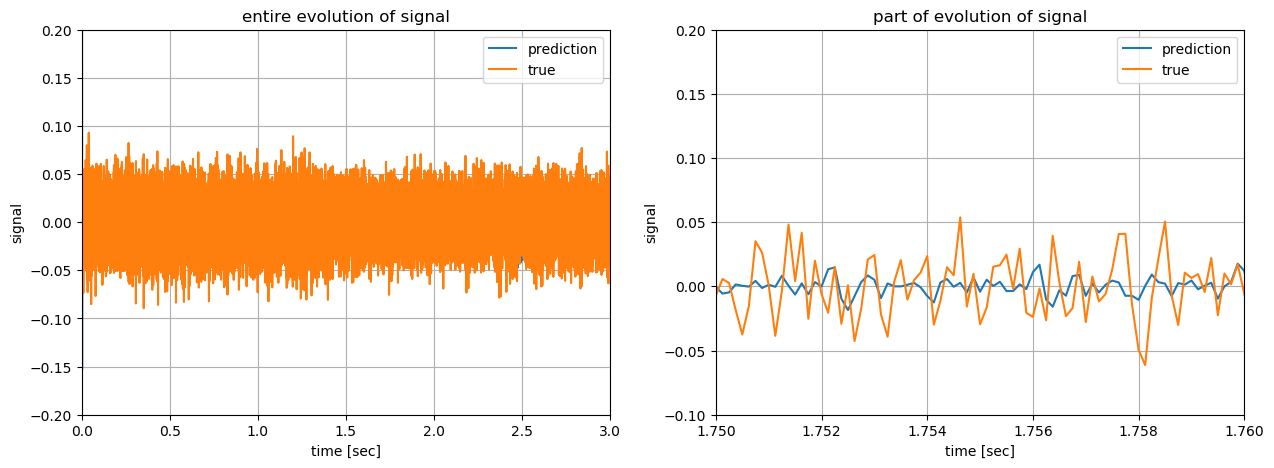

In [15]:
# create figure 
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot prediction of frequency component
ax[1].plot(t[1:end], x1_μ_pred[1:end], label="prediction"), ax[2].plot(t[1:end], x1_μ_pred[1:end], label="prediction")

# plot true evolution of frequency component # add offset because prediction is only performed for second sample forwards
ax[1].plot(t[1:end], x_1[1:end], label="true"), ax[2].plot(t[1:end], x_1[1:end], label="true") 

# change visualization
ax[1].legend(), ax[1].grid(), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("signal"), ax[1].set_title("entire evolution of signal"), ax[1].set_xlim(0, 3)
ax[2].legend(), ax[2].grid(), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("signal"), ax[2].set_title("part of evolution of signal")
ax[2].set_xlim(1.75, 1.76), ax[2].set_ylim(-0.1,0.2), ax[1].set_ylim(-0.2,0.2)

# create audioplayers
audioplayers(x_tot, x_1, x1_μ_pred, fs=fs_desired)
;

## Speech 

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQBdyoC8JHWEvlIoWb1A0DI9/BnOvZzX1L2br4W+132nvUuewbzXmeW90fkiPXsSfb2hVcK76mX1PRb3rz2pOME89QZsvXzjVryDZu496s8VPW+irr3tSPG8r63SPFIlbT6EyOc9TRzTvZptKz0D9Pk9JfsePpl2Kz1aZ0K+Z/BdO/g1Pb3ubv29naqsvXAUir7vfeW9T4yHu0p4hrmlol09mej8vZFpjL1FrAI+wL2QPdPLwT2ha8C7MoiqvcqUNz3pspE8WZK8vM3lVDunn5I9aIlbPnEI2j2Ofsq9txf3PbhzyT3c4zI+51yaPIiCJb6BaTg8it9QvWJIGb4Lj569r0YmviKcRr2WGdW8WnzRvGWJyz1OUDa+B4IuvSEI3ztrtuI98I0iPt9YQrrRUJq9hEzYPJevgL0juJS9vHkxPf7OqT3LN3Q+WkgyPR/sDr0DooM9G52YPVM/BD7Mywa9megxvqiC0zzCFxe9Gokkvssxk71lcxC+rSh6vOmrk717zfW88dF4PUqgIL5RrgQ9V0/cPSMKtz0b6609z8yjvBUNl72eEMe8zHi0u73Y9TyFzpA9F0eyPY6VZT6HGLA9OsfevSquaj2Nx+Y96DLPPWBwPb11QAS+hnNpPbuNpr1fWAS+kPCBvS6CK75ZEnC9OIy1vXaS9LzGkRY8TuGlvTN8azwXo6M9kvGJPZl6sTyjSoa9wirqvClmTD2AXbQ7YNwDPW00DT1Bdwo+cuENPotp0D033Te9BURGPeIJCj7+0RI9lukivZTME74AKtK7aKoivUARm71oxgy97XEIvg3R4b2tm669umyHvOunMLwQDaS9KAWGvENZcz0bbts8Q7ThPCiqVL0JG8u8Xl/hO6Ldbj1poqE9YP0xu2Z6Dz5k4xU+dpZXPQW9zjx3m4Q9BHqVPTbyLrtVqHu9zv/7vHu1fT0oOT89pGQ5vV6zfL28i6u9Ez3QvReAZb0xdyM9StNQPeWXkL17q5y9YqSZvWvMQr0TtBC8aq2NvIfx2LxkhA4802qoPJwPPbxNnLe8DW+jPHO0MDzrlA68MZzIPIYScDxpWHo9Di6FPTcRhDyV4SU9UqwOPcCVoDwxvc482kPqPCl0QzzXm089o00UvUr3KjvEC7a7czPvvEnv2b3PSii9e64wvT6cHrwu65m9ByCgvJ/tMDwDntq5anhSvdV+ib1Felk4f5WFvduIErwNEuo8cBjIPSMNL7wb53A9tRkAPQjuR7qYOww9U16qPapMgT0NLyU9DJexPbQcyDzeOC08FE/HvAC2Bb0v6EK82974vZmgML1aLcm7cqsAvIPr1rx+uFK8F8MTvWegk73GKk+9BB8ZO5dEHTx5rMi8KPEEPW181LyHwUa9yoM7vJOfYTyTJJA72exzPSN5nzts9jU9oJVMvGe7qj3r7LA9VjeNPZJraDuR6Zw9hDxQO9Y+6TvBsUa9OfUgvJCdDD2V6m09PqsQvf6ap71viCa9kgSEvYHMNDzjxR67IqNNPGTLfb2hjHW82Yn8vMiDPbqgpC29hMH1vOudJ716sJS8oraPvXwUy7oi9hQ9P7+kPRJWqj1ypEa8VIijPOBIw7zUOVA8xDJ/PcOknD35s3o9KCfeO0SW8TulqUa8SqlOPPBUErwR0nE8ObzxvHupkr3058G9bMFXvSIie7zXdjE9JCeQPcUseL1y/s+94c2Lvb5f3Llt0Yy7BQTiu7qCozx6yIE8diGPPDREb71m2Gw9brt6PLmVcD3c+fA9YlSqPeDYbDxWcQy9QS1iO950xjw7WE091EMGPPgsDD3CV7i85yGCvb0Z0ryzk/s80wacu9m6tL3KBui8wjtHvLk2jTm56ZC8YZTaPLrlV73XKrq90CFmvUfGk70O+TG8cWNGvEarID3fynw9shaHPe3M2jwXGaQ9g7X+PDxh9zzpb4c9q2XVPLxONT2z1ZW84W/kO4u0vLx0st28FDH3PKkiaDxyl2y9OLNhup5YRb1oHR48UuP3vLc1o7wGLIS7Y5hMvElEjr1MsPW9+IFyvU+pKb356rG7zvnsPJ7ZGbpM4JM8e4cHvAY2Cbw51u06rgy4PcfpoT2tGCc9VbNRPZCNPj1GEC49jtM3u8Q1hbwc9/K8yijSvFQY3zlBKqU8SR+6O5hZjD3sC+K86e0fvd4BEr02zaS9S1uBPECkCL3O2VO9+wubvEzAiL2dheG8i6JuvEN9HT2xNYg7IN5gvfHDCL1apdU8tfIXPK67HT2Zctw9QaJePW1ktT1aYvq8ERLgPP6+fD2FHaA9JLiLPRCShD2tzD08gqrxvI892bwfxKW9SvSWvMQAHjtXw+i4RkIjPDS+cDwKgdm8A3t4vczD9r1citK9fteNvZ8tk73SoYq9QsCzu6YJKr2h8AW9JvQQPLDEbDyzNMY87wi5PE8leD0nAns91j2TPWRwyD2r/Yw9JQCovHtFpzzi8tE8Nf3JO/buLr2jJiQ8OmIou9jtEr3VLHK8GMQgPdeN3DxTlxi9Wo6WvXxQjr3nF8y9zoL0vbTrnL2Z2uq8mik/PIrfFb1ZkvS8BxXsvAe+a7rNbkI9qtYDPjPjvz0W2to9J61kPVAq/zzXgNY8PhPpPAX6vTyk1rC7w3H5PPPJez2FSFi8cTwHu9HUOrsACn+83Q6SvInn07xQehO9tjOJvYGvVb1xFlS9vU0dvf9For19tB+8U9ZWvWxCV7wusry6UHIBPbKUCD0O3xs9OjuBPRNUSj3Urig98biNPQ8utT1e+cs9DV83PUIk2jxQyQI9i2aoPTSXWLt9rh49tttWPKpN3rzuJXK78pWovNcONr07ZBS9E/6fvBICGL1HXS698OfKvYXCJL0hHzW9QhgDvRccHj134l48Y8rdO3WoPLxhela9rS7CvOP0R70M0Hg91rRzPXFhoj0XAlo9aB2pPbzAvj08vqo96cQAPaaDBT1NxqI8XlyHvHU3ALwiT6g8YgU5u2IRsLziRGW9GhGgvVu3Dr1/e469OkCHvRkdabxLewy9tjeDvbLITL3u6Qg8wqS1u+majb06cz69RVs5vctFTbzPOWq9QNgSvNyzMD1BKRE9QfayPcDBtj3tOTI9q5UXPLhcFD22QYS62ZIzPMTiZDpUDge8s0oAva5F5r1BO6O9oWa9vA8lUr2ZWnK8EvwRvT6QfrlWjn+8039IvYfUuL2TBRk86zVMvUXSLr0ef5y8pN6xvB5VTTyXKii9AR59PLRx87lBwpA9brTPPHq8SzwYr849fdWOPRDSgDyYVVm5FojAPKrvPjp9OxK9nGv7O2IpoLyqLoa9SQmhOpVIMT3Y5Qy82t4Uva4yEb1RuoC9sj2+vdB8KL1ojxK9JHLQvF5ipL2mxAc9tnx/vJ+ME7xWnAe97qJVPaqukz2t3xI91WumPUCKhz0cmZQ9s9WEPVwgFb3KSrG8NJ8mvSxqVj1v8qw9AHkmPdUchT0F4jy91418vUl3QL0g/V68GpK4vPNEfr10/S08uMwuvNlJArwEhVi983CVvSu2ZDyCp9Y6jM/tuooK3ryWfek947gzPYmRuj2SFac9i6zkPU3TzTtfcpW7o6WkPTVqhT3qFuc9LjjovKmWILy6WX099JdMvPO7hT0CLo+8L5vmvOs5Bb38L3+9C7CmvDNc97xx7le9dxHfvMyYB72/rHK9nplWvOTQtr2xKD29tKLgvLBBVz2c6qM92WC+PXlYjj348q49XltEPS0oE73swws+NATqPeK3KD4O/RY9Uijsvd8Zbz2w/pS9IYlUvQoVn73QIfy9p2QzvFuE87xDF5W98YcIvVwN7b3yHq28GNWsO+M5P71c+0M9HUcsvHXgJb371GU9mH42PVojhD1jh

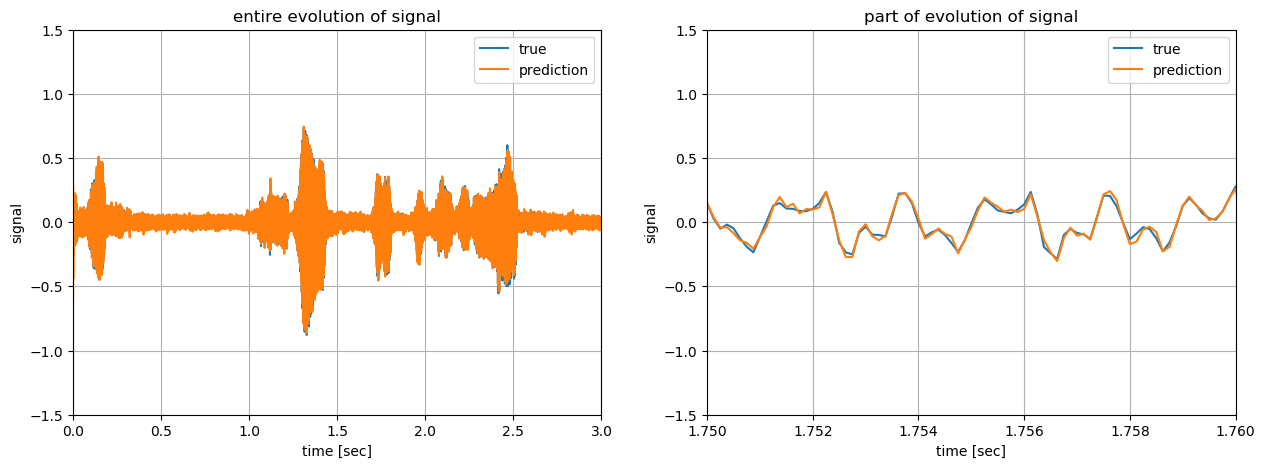

In [13]:
# create figure 
_, ax = plt.subplots(ncols=2, figsize=(15,5))


# plot true evolution of frequency component # add offset because prediction is only performed for second sample forwards
ax[1].plot(t[1:end], x_2[1:end], label="true"), ax[2].plot(t[1:end], x_2[1:end], label="true") 
# plot prediction of frequency component
ax[1].plot(t[1:end], x2_μ_pred[1:end], label="prediction"), ax[2].plot(t[1:end], x2_μ_pred[1:end], label="prediction")

# change visualization
ax[1].legend(), ax[1].grid(), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("signal"), ax[1].set_title("entire evolution of signal"), ax[1].set_xlim(0, 3)
ax[2].legend(), ax[2].grid(), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("signal"), ax[2].set_title("part of evolution of signal")
ax[2].set_xlim(1.75, 1.76), ax[2].set_ylim(-1.5,1.5), ax[1].set_ylim(-1.5,1.5)

# create audioplayers
audioplayers(x_tot, x_2, x2_μ_pred, fs=fs_desired)
;